<a href="https://colab.research.google.com/github/ivel160/Hairstyle-recommend/blob/main/hairstyle_recommend.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [1]:
!pip install fastai --upgrade

Requirement already up-to-date: fastai in /usr/local/lib/python3.7/dist-packages (2.4)


In [2]:
#imports
from fastai.vision.all import *
from fastai.callback.tracker import SaveModelCallback

import numpy as np
import pandas as pd
import glob
from tqdm.auto import tqdm
from plotnine import *

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
!pip install dlib
!pip install cmake
!pip install face_recognition

In [5]:
from fastai.basics import *
from fastai.tabular.core import *
from fastai.tabular.model import *

In [6]:
from fastai.tabular.data import *

# Model

In [7]:
train = pd.read_csv('/content/drive/MyDrive/Hairstyle Recommend/all_features.csv')
train = train.drop(['filenum','filename','Unnamed: 0'], axis=1)
train = train.dropna()
train

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,Width,Height,H_W_Ratio,Jaw_width,J_F_Ratio,MJ_width,MJ_J_width,classified_shape
0,75.0,98.0,75.0,118.0,76.0,138.0,79.0,158.0,87.0,175.0,99.0,190.0,113.0,204.0,129.0,217.0,147.0,222.0,166.0,219.0,182.0,207.0,197.0,193.0,209.0,178.0,217.0,160.0,220.0,140.0,223.0,119.0,225.0,99.0,86.0,84.0,96.0,77.0,108.0,75.0,...,139.0,190.0,129.0,183.0,119.0,167.0,125.0,168.0,140.0,177.0,149.0,178.0,156.0,178.0,172.0,170.0,30.141386,34.695154,40.205768,46.735705,51.927218,56.309932,62.102729,74.475889,81.027373,66.801409,59.886267,54.637538,48.468229,41.676880,36.422283,32.380678,150.003333,212.084889,1.413868,69.065187,0.460424,122.036880,1.766981,heart
1,75.0,98.0,76.0,117.0,79.0,136.0,82.0,154.0,88.0,173.0,98.0,189.0,111.0,203.0,130.0,212.0,151.0,215.0,172.0,212.0,190.0,203.0,204.0,189.0,213.0,173.0,219.0,154.0,223.0,135.0,225.0,117.0,226.0,97.0,89.0,80.0,98.0,72.0,110.0,71.0,...,141.0,186.0,131.0,181.0,122.0,171.0,127.0,171.0,141.0,171.0,150.0,172.0,158.0,172.0,173.0,172.0,33.006651,37.427051,42.345804,48.521453,56.309932,63.868999,73.300756,81.869898,81.869898,72.897271,63.868999,55.885527,48.106027,41.987212,37.056528,32.439763,151.003311,210.038092,1.390950,79.000000,0.523167,125.000000,1.582278,heart
2,76.0,106.0,78.0,125.0,81.0,143.0,84.0,163.0,90.0,181.0,101.0,196.0,117.0,209.0,133.0,220.0,151.0,224.0,169.0,221.0,187.0,210.0,202.0,197.0,214.0,182.0,220.0,163.0,223.0,143.0,226.0,123.0,228.0,103.0,87.0,89.0,98.0,82.0,112.0,80.0,...,142.0,187.0,132.0,183.0,122.0,175.0,127.0,177.0,142.0,178.0,149.0,179.0,156.0,178.0,173.0,177.0,32.439763,36.404089,40.833495,47.683775,54.819301,60.751174,66.194056,77.471192,80.537678,68.749494,62.102729,56.309932,48.521453,41.633539,36.596629,32.471192,152.029602,218.036694,1.434173,70.007142,0.460484,124.004032,1.771305,heart
3,71.0,99.0,74.0,119.0,77.0,139.0,80.0,159.0,88.0,177.0,101.0,193.0,116.0,208.0,132.0,223.0,149.0,227.0,167.0,223.0,184.0,209.0,198.0,194.0,212.0,178.0,220.0,160.0,223.0,140.0,226.0,121.0,228.0,101.0,83.0,89.0,94.0,82.0,108.0,81.0,...,140.0,190.0,126.0,183.0,113.0,165.0,119.0,167.0,140.0,181.0,150.0,182.0,161.0,180.0,181.0,167.0,31.357085,34.777831,39.289407,45.418210,50.659482,54.688787,60.068488,76.759480,77.471192,62.783888,56.040940,52.125016,46.660282,40.383648,35.995221,32.087059,157.012738,220.009091,1.401218,68.007353,0.433133,124.004032,1.823392,heart
4,80.0,99.0,83.0,118.0,86.0,137.0,89.0,156.0,95.0,174.0,105.0,190.0,119.0,204.0,134.0,217.0,153.0,221.0,171.0,217.0,189.0,205.0,204.0,191.0,216.0,174.0,222.0,156.0,225.0,136.0,227.0,116.0,228.0,96.0,87.0,88.0,96.0,81.0,108.0,81.0,...,142.0,187.0,131.0,181.0,119.0,165.0,125.0,167.0,142.0,178.0,152.0,179.0,162.0,178.0,181.0,165.0,30.894642,34.200484,38.576530,44.555856,50.980600,57.144278,63.434949,78.111342,77.471192,66.037511,59.534455,53.275893,46.709814,40.266562,35.174723,30.963757,148.030402,214.233517,1.447226,70.007142,0.472924,121.000000,1.728395,heart
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1519,69.0,95.0,72.0,116.0,77.0,136.0,80.0,156.0,87.0,175.0,100.0,190.0,117.0,204.0,135.0,215.0,153.0,218.0,170.0,215.0,188.0,204.0,204.0,191.0,216.0,176.0,222.0,157.0,225.0,137.0,229.0,117.0,231.0,96.0,82.0,91.0,93.0,84.0,107.0,82.0,...,145.0,184.0,134.0,180.0,121.0,170.0,127.0,171.0,145.0,173.0,152.0,174.0,160.0,172.0,176.0,170.0,34.330217,38.453709,42.825256,49.658254,56.915147,62.152422,68.749494,80.537678,79.992020,68.198591,62.102729,56.309932,48.521453,41.633539,36.960555,32.592581,162.003086,206.087360,1.272120,71.

In [8]:
train.shape

(1504, 168)

In [9]:
procs = [Normalize]
dep_var = 'classified_shape'
cont,cat = cont_cat_split(train, 1, dep_var=dep_var)
splits = RandomSplitter(valid_pct=0.2)(range_of(train))

In [10]:
to = TabularPandas(train, procs, cat, cont, y_names=dep_var, splits=splits)

In [11]:
dls = to.dataloaders(64)

In [12]:
dls.show_batch()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,Width,Height,H_W_Ratio,Jaw_width,J_F_Ratio,MJ_width,MJ_J_width,classified_shape
0,77.0,106.0,80.0,127.0,84.0,148.0,86.0,168.0,90.0,188.000000,99.0,203.0,113.0,216.000000,129.0,226.0,148.0,230.0,168.0,229.0,189.0,220.0,207.0,209.0,220.0,192.000001,227.0,172.000001,231.0,150.0,235.0,128.0,239.0,106.0,86.0,88.0,94.0,79.0,107.0,76.0,121.0,78.0,134.0,84.0,163.0,84.0,178.0,78.0,193.0,75.0,208.0,79.0,218.0,90.0,148.0,101.0,148.0,115.0,147.0,130.0,146.0,144.0,136.0,152.0,141.0,155.0,147.0,157.0,153.0,155.0,160.0,154.0,103.0,102.0,111.0,96.0,122.0,96.0,130.0,105.0,120.0,107.0,110.0,107.0,170.0,105.0,179.0,97.0,190.0,96.0,198.0,103.0,191.0,108.0,180.0,108.0,120.0,179.0,131.0,175.0,140.0,173.0,147.0,175.0,155.0,174.0,166.0,176.0,179.0,182.000001,172.0,183.0,155.0,180.0,147.0,180.0,140.0,179.0,127.0,180.0,179.0,182.000001,166.0,191.0,154.0,194.0,146.0,194.0,138.0,192.0,129.0,188.0,120.0,179.0,127.0,180.0,139.0,184.0,147.0,185.0,155.0,185.0,172.0,183.0,29.794617,33.432560,37.971603,45.000000,54.090279,61.144340,68.198593,78.111343,87.137596,76.293037,70.407714,62.175903,53.714733,46.054405,40.462227,36.273865,162.000000,230.000000,1.419753,76.105194,0.469785,130.061524,1.708970,square
1,73.0,104.0,75.0,123.0,78.0,141.0,82.0,160.0,89.0,178.000000,102.0,192.0,118.0,204.000000,135.0,212.0,154.0,214.0,171.0,209.0,186.0,200.0,199.0,187.0,208.0,173.000000,213.0,157.000000,215.0,140.0,217.0,124.0,217.0,107.0,84.0,85.0,95.0,76.0,109.0,73.0,123.0,76.0,137.0,81.0,166.0,79.0,178.0,74.0,191.0,72.0,204.0,74.0,213.0,82.0,152.0,99.0,152.0,111.0,152.0,123.0,152.0,135.0,138.0,145.0,145.0,146.0,152.0,148.0,158.0,146.0,164.0,145.0,101.0,102.0,111.0,96.0,122.0,97.0,131.0,105.0,121.0,108.0,110.0,107.0,171.0,104.0,180.0,96.0,191.0,96.0,199.0,102.0,192.0,107.0,181.0,107.0,121.0,168.0,134.0,164.0,145.0,161.0,151.0,163.0,158.0,161.0,169.0,164.0,180.0,167.000000,176.0,168.0,159.0,169.0,152.0,170.0,145.0,169.0,126.0,169.0,180.0,167.000000,170.0,176.0,160.0,181.0,152.0,182.0,145.0,181.0,134.0,178.0,121.0,168.0,126.0,169.0,146.0,170.0,152.0,171.0,159.0,170.0,176.0,168.0,36.366581,40.962288,46.153450,53.130104,61.020294,67.067902,74.475891,83.990997,73.610458,66.370621,59.036243,52.792080,45.987759,39.499588,34.992020,30.488941,144.031250,206.038834,1.430515,68.117546,0.472936,119.104996,1.748522,round
2,72.0,109.0,74.0,130.0,77.0,151.0,79.0,171.0,85.0,190.000000,96.0,205.0,112.0,217.000000,131.0,227.0,152.0,230.0,173.0,226.0,191.0,215.0,206.0,202.0,217.0,187.000000,222.0,168.000000,222.0,147.0,226.0,127.0,229.0,106.0,85.0,86.0,96.0,77.0,111.0,75.0,126.0,79.0,140.0,86.0,159.0,86.0,173.0,78.0,188.0,75.0,203.0,77.0,214.0,86.0,150.0,97.0,150.0,110.0,150.0,123.0,150.0,136.0,135.0,144.0,142.0,147.0,150.0,150.0,157.0,147.0,164.0,145.0,102.0,102.0,111.0,97.0,121.0,98.0,129.0,104.0,120.0,106.0,110.0,105.0,170.0,104.0,178.0,98.0,189.0,97.0,197.0,102.0,189.0,105.0,180.0,105.0,115.0,173.0,127.0,165.0,140.0,161.0,150.0,162.0,160.0,161.0,172.0,165.0,185.0,173.000000,179.0,174.0,160.0,169.0,150.0,170.0,140.0,169.0,120.0,174.0,185.0,173.000000,173.0,186.0,160.0,192.0,149.0,193.0,139.0,192.0,126.0,186.0,115.0,173.0,120.0,174.0,139.0,181.0,149.0,182.0,160.0,181.0,179.0,174.0,33.470963,37.954231,43.512131,51.054192,59.162167,65.942650,71.995842,81.869896,79.215706,68.962486,62.592426,56.513832,48.468227,40.143394,35.695229,31.838947,157.028656,240.033324,1.528596,79.025314,0.503254,132.034088,1.670782,oval
3,82.0,102.0,83.0,121.0,85.0,140.0,89.0,159.0,94.0,178.000000,104.0,1

In [13]:
class TabularLearner(Learner):
    "`Learner` for tabular data"
    def predict(self, row):
        "Predict on a Pandas Series"
        dl = self.dls.test_dl(row.to_frame().T)
        dl.dataset.conts = dl.dataset.conts.astype(np.float32)
        inp,preds,_,dec_preds = self.get_preds(dl=dl, with_input=True, with_decoded=True)
        b = (*tuplify(inp),*tuplify(dec_preds))
        full_dec = self.dls.decode(b)
        return full_dec,dec_preds[0],preds[0]

In [14]:
@delegates(Learner.__init__)
def tabular_learner(dls, layers=None, emb_szs=None, config=None, n_out=None, y_range=None, **kwargs):
    "Get a `Learner` using `dls`, with `metrics`, including a `TabularModel` created using the remaining params."
    if config is None: config = tabular_config()
    if layers is None: layers = [200,100]
    to = dls.train_ds
    emb_szs = get_emb_sz(dls.train_ds, {} if emb_szs is None else emb_szs)
    if n_out is None: n_out = get_c(dls)
    assert n_out, "`n_out` is not defined, and could not be inferred from data, set `dls.c` or pass `n_out`"
    if y_range is None and 'y_range' in config: y_range = config.pop('y_range')
    model = TabularModel(emb_szs, len(dls.cont_names), n_out, layers, y_range=y_range, **config)
    return TabularLearner(dls, model, **kwargs)

In [15]:
learn = tabular_learner(dls, metrics=accuracy, layers=[1024,512,256])

In [16]:
learn.fit_one_cycle(10, 1e-3, cbs=[SaveModelCallback(monitor='accuracy'),])

epoch,train_loss,valid_loss,accuracy,time
0,1.449961,1.307442,0.496667,00:00
1,1.117138,0.873303,0.686667,00:00
2,0.885378,0.917354,0.676667,00:00
3,0.732199,0.838810,0.710000,00:00
4,0.595559,0.821021,0.693333,00:00
5,0.465319,0.686397,0.750000,00:00
6,0.349066,0.676629,0.753333,00:00
7,0.259668,0.640645,0.786667,00:00
8,0.192027,0.603521,0.783333,00:00
9,0.147017,0.619025,0.776667,00:00


Better model found at epoch 0 with accuracy value: 0.49666666984558105.
Better model found at epoch 1 with accuracy value: 0.6866666674613953.
Better model found at epoch 3 with accuracy value: 0.7099999785423279.
Better model found at epoch 5 with accuracy value: 0.75.
Better model found at epoch 6 with accuracy value: 0.753333330154419.
Better model found at epoch 7 with accuracy value: 0.7866666913032532.


In [17]:
preds,targets=learn.get_preds()

In [18]:
preds

tensor([[2.2463e-03, 3.0330e-02, 2.9056e-04, 2.9490e-02, 9.3764e-01],
        [6.6282e-04, 9.9854e-01, 1.9757e-04, 2.3453e-04, 3.6749e-04],
        [3.2920e-02, 9.1369e-01, 2.0451e-02, 1.1485e-02, 2.1451e-02],
        ...,
        [2.3237e-03, 1.7792e-02, 9.5520e-01, 6.4243e-03, 1.8262e-02],
        [5.6752e-01, 1.3304e-01, 1.1012e-01, 1.8843e-01, 8.7724e-04],
        [8.3520e-01, 1.8515e-02, 3.5523e-04, 1.2858e-01, 1.7350e-02]])

In [19]:
interp = ClassificationInterpretation.from_learner(learn)

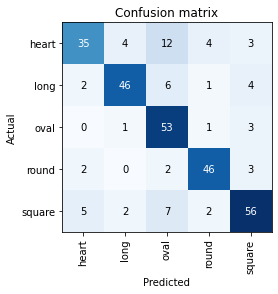

In [20]:
interp.plot_confusion_matrix()

# Functions

In [21]:
df = pd.DataFrame(columns = ['0','1','2','3','4','5','6','7','8','9','10','11',	'12',	'13',	'14',	'15',	'16','17',
                             '18',	'19',	'20',	'21',	'22',	'23',	'24','25',	'26',	'27',	'28',	'29',
                             '30',	'31',	'32',	'33',	'34',	'35',	'36',	'37',	'38',	'39',	'40',	'41',
                             '42',	'43',	'44',	'45',	'46',	'47',	'48',	'49',	'50',	'51',	'52',	'53',
                             '54',	'55',	'56',	'57',	'58',	'59',	'60',	'61',	'62',	'63',	'64',	'65',
                             '66',	'67',	'68',	'69',	'70',	'71',	'72',	'73',	'74',	'75',	'76',	'77',
                             '78',	'79',	'80',	'81',	'82',	'83',	'84',	'85',	'86',	'87',	'88',	'89',
                             '90',	'91',	'92',	'93',	'94',	'95',	'96',	'97',	'98',	'99',	'100',	'101',
                             '102',	'103',	'104',	'105',	'106',	'107',	'108',	'109',	'110',	'111',	'112',	'113',
                             '114',	'115',	'116',	'117',	'118',	'119',	'120',	'121',	'122',	'123',	'124',	'125',
                             '126',	'127',	'128',	'129',	'130',	'131',	'132',	'133',	'134',	'135',	'136',	'137',
                             '138',	'139',	'140',	'141',	'142',	'143','A1','A2','A3','A4','A5','A6','A7','A8','A9',
                            'A10','A11','A12','A13','A14','A15','A16','Width','Height','H_W_Ratio','Jaw_width','J_F_Ratio',
                             'MJ_width','MJ_J_width'])

In [22]:
import requests
from matplotlib.pyplot import imshow
import time
from PIL import Image, ImageDraw
import face_recognition
import pandas as pd
import numpy as np
from os.path import basename
import math
import pathlib
from pathlib import Path
import os
import random

In [23]:
def distance(p1,p2):
    dx = p2[0] - p1[0]
    dy = p2[1] - p1[1]
    return math.sqrt(dx*dx+dy*dy)

In [24]:
def scale_rotate_translate(image, angle, center = None, new_center = None, scale = None, resample=Image.BICUBIC):
    if (scale is None) and (center is None):
        return image.rotate(angle=angle, resample=resample)
    nx,ny = x,y = center
    sx=sy=1.0
    if new_center:
        (nx,ny) = new_center
    if scale:
        (sx,sy) = (scale, scale)
    cosine = math.cos(angle)
    sine = math.sin(angle)
    a = cosine/sx
    b = sine/sx
    c = x-nx*a-ny*b
    d = -sine/sy
    e = cosine/sy
    f = y-nx*d-ny*e
    return image.transform(image.size, Image.AFFINE, (a,b,c,d,e,f), resample=resample)

In [25]:
def crop_face(image, eye_left=(0,0), eye_right=(0,0), offset_pct=(0.3,0.3), dest_sz = (600,600)):
    # calculate offsets in original image
    offset_h = math.floor(float(offset_pct[0])*dest_sz[0])
    offset_v = math.floor(float(offset_pct[1])*dest_sz[1])
    # get the direction
    eye_direction = (eye_right[0] - eye_left[0], eye_right[1] - eye_left[1])
    # calc rotation angle in radians
    rotation = -math.atan2(float(eye_direction[1]),float(eye_direction[0]))
    # distance between them
    dist = distance(eye_left, eye_right)
    # calculate the reference eye-width
    reference = dest_sz[0] - 2.0*offset_h
    # scale factor
    scale = float(dist)/float(reference)
    # rotate original around the left eye

    image = scale_rotate_translate(image, center=eye_left, angle=rotation)
    # crop the rotated image
    crop_xy = (eye_left[0] - scale*offset_h, eye_left[1] - scale*offset_v)
    crop_size = (dest_sz[0]*scale, dest_sz[1]*scale)
    image = image.crop((int(crop_xy[0]), int(crop_xy[1]), int(crop_xy[0]+crop_size[0]), int(crop_xy[1]+crop_size[1])))
    # resize it
    image = image.resize(dest_sz, Image.ANTIALIAS)
    return image

In [26]:
def make_face_df_save(image_select,filenum,df):
    
    # This function looks at one image, draws points and saves points to DF
    pts = []
    # filenum = 0   # need this to iterate through the dataframe to append rows
    face = 0
    image = face_recognition.load_image_file(image_select)
    face_landmarks_list = face_recognition.face_landmarks(image)
    
    for face_landmarks in face_landmarks_list:
        face += 1
        if face >1:    # this will only measure one face per image
            break
        else:
            # Print the location of each facial feature in this image
            facial_features = [
                'chin',
                'left_eyebrow',
                'right_eyebrow',
                'nose_bridge',
                'nose_tip',
                'left_eye',
                'right_eye',
                'top_lip',
                'bottom_lip'
                ]

            for facial_feature in facial_features:
                # put each point in a COLUMN
                for  point in  face_landmarks[facial_feature]:
                    for pix in point:
                        pts.append(pix)
               
        pil_image = Image.fromarray(image)
        d = ImageDraw.Draw(pil_image)
        
        eyes = []
        lex = pts[72]
        ley = pts[73]
        rex = pts[90]
        rey = pts[91]
        eyes.append(pts[72:74])
        eyes.append(pts[90:92])

        image =  Image.open(image_select)
        crop_image = crop_face(image, eye_left=(lex, ley), eye_right=(rex, rey), offset_pct=(0.34,0.34), dest_sz=(300,300))
        try:
            crop_image.save(str(image_select)+"_NEW_cropped.jpg")
        except:
            continue
        #crop_image.show()
        
        nn = str(image_select)+"_NEW_cropped.jpg"
        pts = []
        face = 0
        image = face_recognition.load_image_file(nn)
        face_landmarks_list = face_recognition.face_landmarks(image)

        for face_landmarks in face_landmarks_list:
            face += 1
            if face >1:    # this will only measure one face per image
                break
            else:
                # Print the location of each facial feature in this image
                facial_features2 = [
                    'chin',
                    'left_eyebrow',
                    'right_eyebrow',
                    'nose_bridge',
                    'nose_tip',
                    'left_eye',
                    'right_eye',
                    'top_lip',
                    'bottom_lip'
                    ]

                for facial_feature in facial_features2:
                    # put each point in a COLUMN
                    for  point in  face_landmarks[facial_feature]:
                        for pix in point:
                            pts.append(pix)

            i = 0
            for j in range(0,17):
                if i != 16:
                    if i != 17:
                        px = pts[i]
                        py = pts[i+1]
                        chin_x = pts[16]   # always the chin x
                        chin_y = pts[17]   # always the chin y

                        x_diff = float(px - chin_x)

                        if(py == chin_y): 
                            y_diff = 0.1
                        if(py < chin_y): 
                            y_diff = float(np.absolute(py-chin_y))
                        if(py > chin_y):
                            y_diff = 0.1
                            print("Error: facial feature is located below the chin.")

                        angle = np.absolute(math.degrees(math.atan(x_diff/y_diff)))

                        pts.append(angle)
                i += 2
        
            pil_image = Image.fromarray(image)
            d = ImageDraw.Draw(pil_image)

            for facial_feature in facial_features2:
                    #d.line(face_landmarks[facial_feature], width=5)
                    d.point(face_landmarks[facial_feature], fill = (255,255,255))
            
            
            pil_image.save(str(image_select) + '_NEW_rotated_pts.jpg', 'JPEG', quality = 100)

            # take_measurements width & height measurements
        msmt = []
        a = pts[0]   ## point 1 x - left side of face 
        b = pts[1]   ## point 1 y
        c = pts[32]  ## point 17 x - right side of face
        d = pts[33]  ## point 17 y

        e = pts[16]  ## point 9 x - chin
        f = pts[17]  ## point 9 y - chin
        #Visual inspection indicates that point 29 is the middle of the face, 
        #so the height of the face is 2X the height between chin & point 29 which are coordinates 56 and 57     
        g = pts[56]  # point 29's x coordinate (mid-face point)
        h = pts[57]   # point 29's y coordinate
        
        i = pts[12]    # point 7 x   for jaw length 
        j = pts[13]    # point 7 y   for jaw length
        k = pts[20]    # point 11 x  for jaw length
        l = pts[21]    # point 11 y  for jaw length
             
        m = pts[8]     # point 5 x   for lower jaw length     
        n = pts[9]     # point 5 y
        o = pts[24]     # point 13 x
        p = pts[25]     # point 13 y

        face_width = np.sqrt(np.square(a - c) + np.square(b - d))
        #print(face_width)
        pts.append(face_width)
        face_height = np.sqrt(np.square(e - g) + np.square(f - h)) * 2   # double the height to the mid-point
        #print(face_height)
        pts.append(face_height)
        height_to_width = face_height/face_width
        
        pts.append(height_to_width)
        
        # JAW width (7-11)
        jaw_width = np.sqrt(np.square(i-k) + np.square(j-l))
        pts.append(jaw_width)
        jaw_width_to_face_width =  jaw_width/face_width
        pts.append(jaw_width_to_face_width)
        
        # mid-JAW width (5-13)
        mid_jaw_width = np.sqrt(np.square(m-o) + np.square(n-p))
        pts.append(mid_jaw_width)
        mid_jaw_width_to_jaw_width =  mid_jaw_width/jaw_width
        pts.append(mid_jaw_width_to_jaw_width)
        
        ### end of new ###
            
        df.loc[filenum] = np.array(pts)
        #imshow(pil_image, cmap='gray')

# Run Example

In [27]:
my_photo = '/content/drive/MyDrive/Hairstyle Recommend/test pics/Blake-Lively.jpg'
file_num = 0
make_face_df_save(my_photo,file_num,df)

In [28]:
row, clas, probs = learn.predict(df.iloc[0])

In [29]:
row.show()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,A11,A12,A13,A14,A15,A16,Width,Height,H_W_Ratio,Jaw_width,J_F_Ratio,MJ_width,MJ_J_width,classified_shape
0,65.0,107.0,68.0,128.0,73.0,147.0,78.0,166.0,86.0,184.0,98.0,200.0,114.0,212.0,133.0,221.0,154.0,222.0,173.0,219.0,191.0,208.0,203.0,194.0,211.0,178.0,216.0,160.0,218.0,141.0,221.0,122.0,223.0,104.0,84.0,88.0,94.0,78.0,109.0,73.0,124.0,74.0,139.0,80.0,166.0,81.0,178.0,76.0,192.0,75.0,204.0,78.0,213.0,87.0,153.0,97.0,153.0,110.0,154.0,123.0,156.0,135.0,141.0,146.0,147.0,148.0,154.0,149.0,160.0,147.0,166.0,144.0,103.0,102.0,112.0,96.0,122.0,96.0,130.0,102.0,121.0,104.0,111.0,104.0,171.0,102.0,179.0,96.0,189.0,96.0,198.0,102.0,190.0,105.0,180.0,104.0,124.0,171.0,135.0,165.0,146.0,162.0,153.0,164.0,161.0,161.0,170.0,163.0,179.0,169.0,174.0,170.0,161.0,169.0,153.0,170.0,145.0,170.0,129.0,172.0,179.0,169.0,171.0,176.0,162.0,180.0,154.0,181.0,146.0,181.0,135.0,178.0,124.0,171.0,129.0,172.0,146.0,171.0,154.0,171.0,162.0,170.0,174.0,170.0,37.736755,42.455196,47.202598,53.615648,60.802514,68.552263,75.963757,87.273689,81.027373,69.274441,60.255119,52.334379,45.0,38.313091,33.822085,30.31678,158.028478,224.008928,1.417523,77.103826,0.487911,125.143917,1.623057,oval


In [30]:
clas, probs

(tensor(2), tensor([0.0509, 0.0529, 0.8916, 0.0019, 0.0026]))

In [31]:
class_names = ['heart', 'long', 'oval', 'round', 'square']
test_shape = class_names[np.argmax(probs)]
test_shape

'oval'

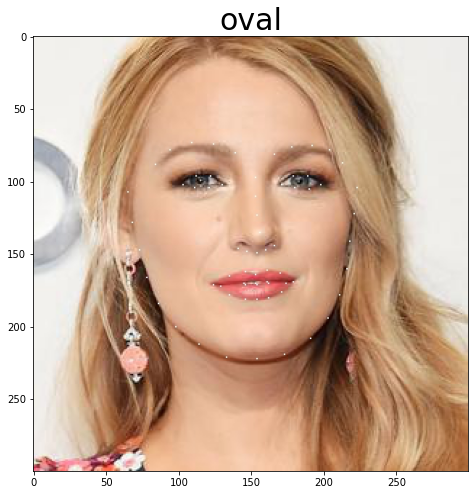

In [32]:
plt.figure(figsize = (8,8))
new_photo = my_photo+'_NEW_rotated_pts.jpg'
img = Image.open(new_photo)
draw = ImageDraw.Draw(img)
plt.title(test_shape, fontsize = 30)
plt.imshow(img)
img.close()

# Recommender

In [33]:
import requests
from PIL import Image, ImageDraw,ImageFont
import face_recognition
import pandas as pd
import numpy as np
from os.path import basename
import math
import pathlib
from pathlib import Path
import os
import random
import matplotlib.pyplot as plt
import uuid

In [34]:
image_dir = "/content/drive/MyDrive/Hairstyle Recommend"

In [35]:
style_df = pd.DataFrame()
style_df = pd.DataFrame(columns = ['face_shape','hair_length','location','filename','score'])

In [36]:
def process_rec_pics(style_df,image_dir = "/content/drive/MyDrive/Hairstyle Recommend"):
    image_root = "/content/drive/MyDrive/Hairstyle Recommend/rec_pics" 
    dir_list = ['heart','long','oval','square','round']
    filenum = 0   
    for dd in dir_list: 
            image_dir = image_root + '/' + dd
            sub_dir = [q for q in pathlib.Path(image_dir).iterdir() if q.is_dir()]
            #print(sub_dir)
            start_j = 0
            end_j = len(sub_dir)

            for j in range(start_j, end_j):
                    #images_dir = [p for p in pathlib.Path(sub_dir[j]).iterdir() if p.is_file()]

                    for p in pathlib.Path(sub_dir[j]).iterdir():
                        shape_array= []

                        face_shape = os.path.basename(os.path.dirname(os.path.dirname(p)))
                        hair_length = os.path.basename(os.path.dirname(p)) 
                        sub_dir_file = p
                        face_file_name = os.path.basename(p)

                        shape_array.append(face_shape)
                        shape_array.append(hair_length)
                        shape_array.append(sub_dir_file)
                        shape_array.append(face_file_name)  
                        
                        random.seed(filenum)  # this keeps the score the same each time I run it
                        rand = random.randint(25,75)  # make a random score to start the rec. engine
                        shape_array.append(rand)

                        style_df.loc[filenum] = np.array(shape_array)

                        filenum += 1
    return(filenum)

In [37]:
process_rec_pics(style_df)

style_df

,face_shape,hair_length,location,filename,score
0,heart,Updo,/content/drive/MyDrive/Hairstyle Recommend/rec_pics/heart/Updo/Brittany Snow (14).jpg,Brittany Snow (14).jpg,49
1,heart,Updo,/content/drive/MyDrive/Hairstyle Recommend/rec_pics/heart/Updo/Ashley Greene (2).jpg,Ashley Greene (2).jpg,33
2,heart,Updo,/content/drive/MyDrive/Hairstyle Recommend/rec_pics/heart/Updo/Ciara (11).jpg,Ciara (11).jpg,28
3,heart,Updo,/content/drive/MyDrive/Hairstyle Recommend/rec_pics/heart/Updo/Brittany Snow (12).jpg,Brittany Snow (12).jpg,40
4,heart,Updo,/content/drive/MyDrive/Hairstyle Recommend/rec_pics/heart/Updo/Cheryl Cole (5).jpg,Cheryl Cole (5).jpg,40
...,...,...,...,...,...
1159,round,Long,/content/drive/MyDrive/Hairstyle Recommend/rec_pics/round/Long/mila kunis 4.jpg,mila kunis 4.jpg,37
1160,round,Long,/content/drive/MyDrive/Hairstyle Recommend/rec_pics/round/Long/Drew Barrymore (8).jpg,Drew Barrymore (8).jpg,53
1161,round,Long,/content/drive/MyDrive/Hairstyle Recommend/rec_pics/round/Long/mila kunis 8.png,mila kunis 8.png,60
1162,round,Long,/content/drive/MyDrive/Hairstyle Recommend/rec_pics/round/Long/mila kunis 5.jpg,mila kunis 5.jpg,55


In [38]:
def run_recommender(file_num):
    name = input("What is your name? ")
    print("Hello, %s." % name)
    face_shape_input = test_shape
    if face_shape_input not in ['heart','long','oval','round','square']:
        face_shape_input = input("What is your face shape?")
    updo_input = input("Would you like to see up-dos? (Y/N)")
    if updo_input in ['n','no','N','No','NO']:
            hair_length_input = input("Is your hair short (shoulder-length shorter) or long?")
            if hair_length_input in ['short','Short','s','S']:
                hair_length_input = 'Short'
            if hair_length_input in ['long','longer','l','L']:
                hair_length_input = 'Long'
    else: hair_length_input = 'Updo'
    
    print(hair_length_input)
    print(face_shape_input)
    r = 6
    
    n_col = 3
    n_row = 2
    recommended_df = style_df.loc[(style_df['face_shape'] ==face_shape_input) & (style_df['hair_length']==       hair_length_input)].sort_values('score', ascending = 0).reset_index(drop=True)
    recommended_df = recommended_df.head(r)
    
    plt.figure(figsize=(5 * n_col, 4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)    
    font = ImageFont.truetype("/content/drive/MyDrive/Hairstyle Recommend/fonts/Arial.ttf", 60)
    for p in range(0,r):
        idea = str(recommended_df.iloc[p]['location'] )
        idea = idea.replace('\\', '/')
        img = Image.open(idea)
        plt.subplot(n_row, n_col, p+1 )
        draw = ImageDraw.Draw(img)
        plt.title(p+1,fontsize = 40)
        plt.xlabel(recommended_df.iloc[p]['score'],fontsize = 20)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)
        img.close()

    plt.show()
    
    time.sleep(2)

    fav = input("Which style is your favorite? ")
    yuck = input("Which style is your least favorite? ")
    # update scores based on fav/least fav

    for row in range(0,r):
        fn = recommended_df.at[row,'filename']
        srow = style_df.index[style_df['filename'] == fn].tolist()
        srow = srow[0]
        #print('Srow %s' %srow)
        row += 1
        if str(row) == str(fav):
            style_df.at[srow,'score'] =  style_df.at[srow,'score'] + 5
        if str(row) == str(yuck):
            style_df.at[srow,'score'] =  style_df.at[srow,'score'] - 5

In [39]:
def run_recommender_face_shape(file_num,style_df,hair_length_input):
    face_shape_input = test_shape
    r = 6
    
    n_col = 3
    n_row = 2
    img_path = []
    recommended_df = style_df.loc[(style_df['face_shape'] ==face_shape_input) & (style_df['hair_length']== hair_length_input)].sort_values('score', ascending = 0).reset_index(drop=True)
    recommended_df = recommended_df.head(r)
    
    plt.figure(figsize=(4 * n_col, 3 * n_row))
    plt.subplots_adjust(bottom=.06, left=.01, right=.99, top=.90, hspace=.50)    
    font = ImageFont.truetype("/content/drive/MyDrive/Hairstyle Recommend/fonts/Arial.ttf", 60)
    for p in range(0,r):
        idea = str(recommended_df.iloc[p]['location'] )
        idea = idea.replace('\\', '/')
        img = Image.open(idea)
        plt.subplot(n_row, n_col, p+1 )
        img_path.append(idea)
        draw = ImageDraw.Draw(img)
        plt.title(p+1,fontsize = 40)
        plt.xlabel(recommended_df.iloc[p]['score'],fontsize = 20)
        plt.xticks([])
        plt.yticks([])
        plt.imshow(img)
        img.close()

    #plt.show()
    img_id = uuid.uuid4()
    img_filename=f"/content/drive/MyDrive/Hairstyle Recommend/output_{img_id}.png"
    plt.savefig(img_filename)
    return img_filename
    #return img_path

# Run Recommender

What is your name? f
Hello, f.
Would you like to see up-dos? (Y/N)n
Is your hair short (shoulder-length shorter) or long?l
Long
oval


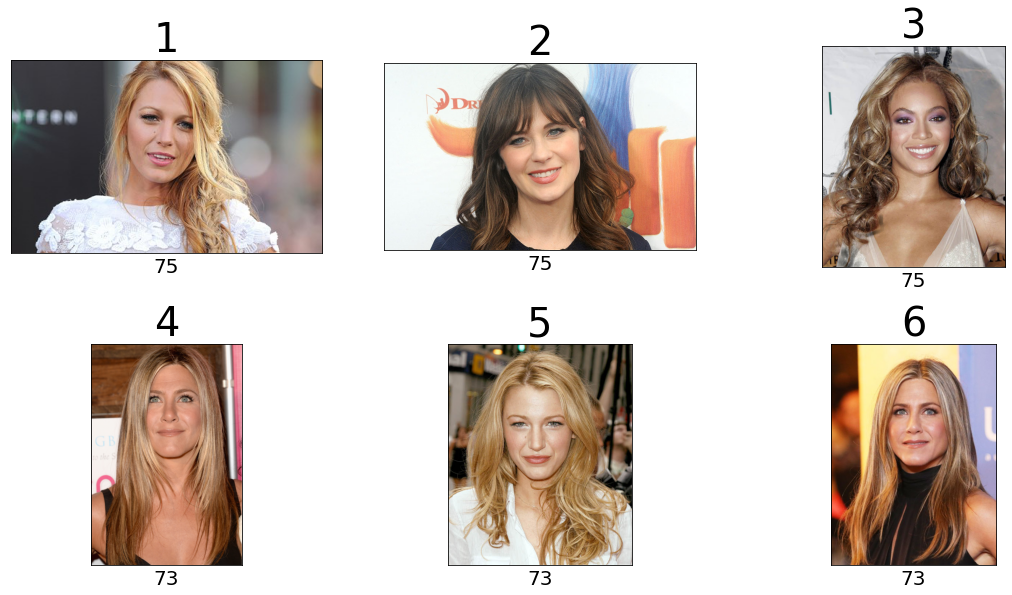

Which style is your favorite? 5
Which style is your least favorite? 3


In [40]:
run_recommender(test_shape[0])

What is your name? f
Hello, f.
Would you like to see up-dos? (Y/N)n
Is your hair short (shoulder-length shorter) or long?l
Long
oval


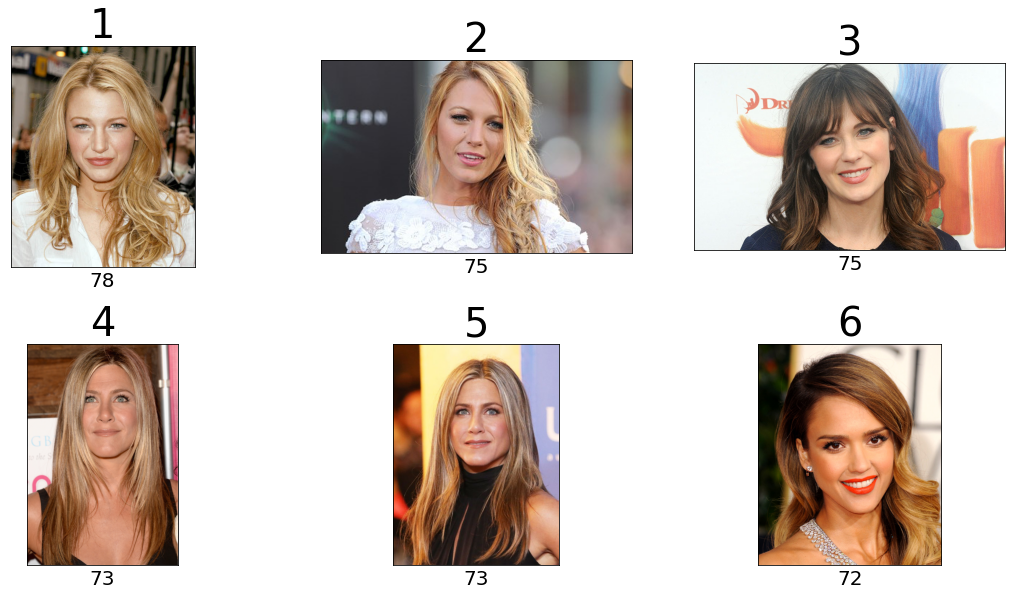

Which style is your favorite? 2
Which style is your least favorite? 6


In [41]:
run_recommender(test_shape[0])